# Self-fulfilling prophecies


We want to show what kind of issues can arise from clustering when it is applied to real people and affects their choices. In the sample code diagonal clusters.ipynb you can see how to create plots.


## (a)
Simulate 1000 points from a bivariate normal distribution $N(\mu, \Sigma)$ with

$$
\mu = 0, \Sigma = \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}.
$$

Plot the data. Pretend these two variables represent the features that an *app* uses to characterize people’s preferences and subsequently cluster them into 3 clusters to propose three possible choices.


Define a sampling function from the standard bivariate normal distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_samples():
    mu = [0, 0]  
    cov = [[1, 0], [0, 1]]  

    samples = np.random.multivariate_normal(mu, cov, 1000)
    return samples



Define a 2D scatter plot function 

In [2]:
def plot_samples(samples):
    
    x = samples[:, 0]
    y = samples[:, 1]

    plt.scatter(x, y)
    plt.show()

Sample and then plot the synthetic data

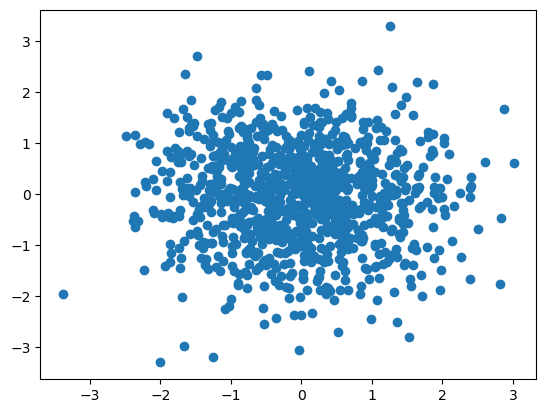

In [3]:
plot_samples(generate_samples())

## (b)
Using the python package `sklearn.cluster.KMeans` fit a 3 cluster model to the data. Plot the three cluster centers and color the data points according to the clusters they are assigned. This is the assignment the app has chosen for this population.

Define a kmeans cluster model with an argument to specify the number of clustering centers

In [4]:
from sklearn.cluster import KMeans

def fit_kmeans(samples, n_clusters=3, random_state=0):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=random_state).fit(samples)
    return kmeans.labels_, kmeans.cluster_centers_

Define a function that plots the cluster centers and color the data according to the clustering result

In [5]:
def plot_clusters(samples, labels, centers):
    plt.scatter(samples[:, 0], samples[:, 1], c=labels)
    plt.scatter(centers[:, 0], centers[:, 1], c='red')
    plt.show()

Sample, cluster and plot

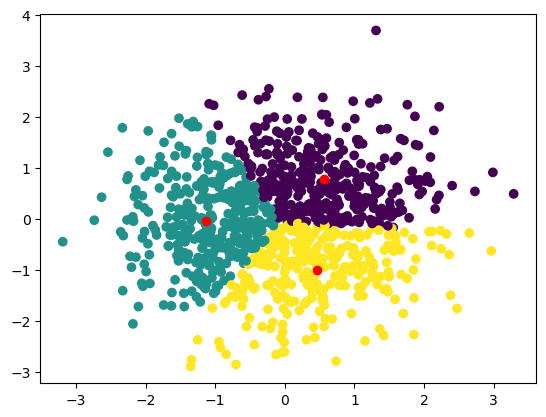

In [6]:
samples = generate_samples()
labels, centers = fit_kmeans(samples, n_clusters=3)

plot_clusters(samples, labels, centers)

## (c)
Now modify each point in the data to move 1% closer to its assigned cluster center. $x_i = .99 ∗ x_i + .01c_i$, where $c_i$ is the cluster center assigned to the i’th data point. This corresponds to a tiny indirect effect of the choice of cluster on the features of the people in the sample. Now repeat the clustering on the modified data.

Define a function to modify points closer to their centers

In [7]:
def move_points(samples, centers, labels):
    return 0.99 * samples  + 0.01 * centers[labels]

Synthesize data, cluster and plot

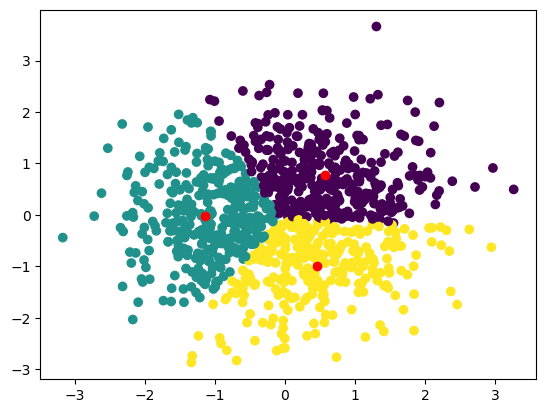

In [8]:
samples_new =  move_points(samples, centers, labels)
labels_new, centers_new = fit_kmeans(samples_new, n_clusters=3)

plt.scatter(samples_new[:, 0], samples_new[:, 1], c=labels_new)
plt.scatter(centers_new[:, 0], centers_new[:, 1], c='red')
plt.show()

## (d)
Imagine the app repeats the clustering analysis every week based on the modified data. Repeat this process 50 times. Plot the original data cloud, and the final data cloud you obtained side by side. Describe what has happened to your original population of diverse individuals after a year (50 weeks).

Setup the iterative clustering routine

In [9]:
def iterative_kmeans(samples, n_clusters=3, n_iter=10):
    labels, centers = fit_kmeans(samples, n_clusters)
    for i in range(n_iter):
        samples = move_points(samples, centers, labels)
        labels, centers = fit_kmeans(samples, n_clusters)
    return samples, labels, centers

Run the algorithm and plot

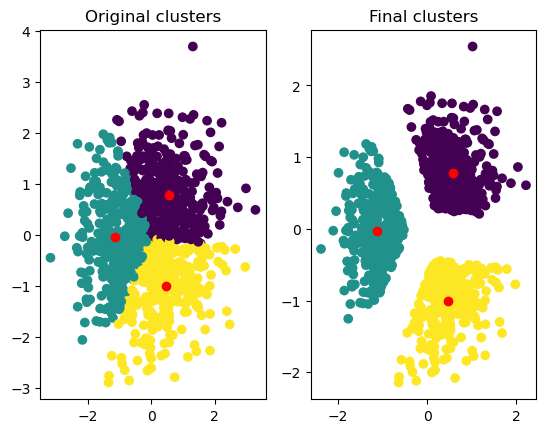

In [10]:
samples_new, labels_new, centers_new = iterative_kmeans(samples, n_clusters=3, n_iter=50)

plt.subplot(121)
plt.scatter(samples[:, 0], samples[:, 1], c=labels)
plt.scatter(centers[:, 0], centers[:, 1], c='red')
plt.title('Original clusters')
plt.subplot(122)
plt.scatter(samples_new[:, 0], samples_new[:, 1], c=labels_new)
plt.scatter(centers_new[:, 0], centers_new[:, 1], c='red')
plt.title('Final clusters')
plt.show()

Originally, there were no noticeable groups. But after clustering and modifying the data iteratively, the groups that were determined arbitrarily initially differed significantly from others, which is the self-fulfilling prophecy.

# Presidential logorrhea
In this problem, you will analyze the lengths of the State of the Union addresses by all US
presidents.


## (a)
The transcripts of all State of the Union addresses can be accessed in the `sou` subfolder of the NLP subfolder of the LSDA data folder in the course Modules page. You can also access this data folder with the link to ‘Course Data’ on the Canvas Syllabus page. File name: speeches.json.
Once you download this to your machine you can load the speeches into python using the json package.
Each speech will now be a string in the list `speeches`.
Write Python code that parses each SOU address, finding end-of-sentence markers. Don’t worry about being too precise about sentence boundaries—as a first approxima- tion, you could find words ending in a period. (But what about “Mr.”?) You can use the file `text processing.ipynb` for some clues on how to process strings in python.

Load the speeches data

In [11]:
import json
speeches=[]
with open("speeches.json") as f:
    for line in f:
        speeches.append(json.loads(line))

Preprocess the data to avoid formatting problems

In [12]:
def preprocess_text(text):
    text = text.replace("\n\n", " ").replace("\n", " ")
    return text

Split the address into sentences based on end-of-sentence markers

In [13]:
import nltk
from nltk.tokenize import sent_tokenize

parsed_speeches = []
for speech in speeches:
    sentences = sent_tokenize(preprocess_text(speech['text'])) 
    parsed_speeches.extend([(speech['president'], sentence, speech['year']) for sentence in sentences])

## (b)
Which President has the longest sentences on average? Which has the shortest sen- tences? Compute the median, 25% and 75% quantiles across all Presidents. What was the longest and shortest sentence ever spoken (or written) in a SOU?

Convert the data into dataframe for easy analysis

In [14]:
import numpy as np
import pandas as pd


df = pd.DataFrame(parsed_speeches, columns=['president', 'sentence', 'year'])
df['length'] = df['sentence'].apply(lambda s: len(s))

Find the presidents with the longest and shortest sentences on average

In [15]:
mean_lengths = df.groupby('president')['length'].mean()
min_president = mean_lengths.idxmin()
max_president = mean_lengths.idxmax()

print(f"President with shortest sentences on average: {min_president}")
print(f"President with longest sentences on average: {max_president}")

President with shortest sentences on average: George Bush
President with longest sentences on average: James Madison


Find the quantile statistics, maximum and minimum

In [16]:
quantiles = df['length'].quantile([0.25, 0.5, 0.75])
print(f"25% quantile: {quantiles[0.25]}, median: {quantiles[0.5]}, 75% quantile: {quantiles[0.75]}")

longest_sentence = df.iloc[df['length'].idxmax()]
shortest_sentence = df.iloc[df['length'].idxmin()]

print(f"Longest sentence: {longest_sentence['length']} characters, by {longest_sentence['president']}")
print(f"The sentence: {longest_sentence['sentence']}")
print(f"Shortest sentence: {shortest_sentence['length']} characters, by {shortest_sentence['president']}")
print(f"The sentence: {shortest_sentence['sentence']}")

25% quantile: 92.0, median: 146.0, 75% quantile: 222.0
Longest sentence: 7007 characters, by Chester A. Arthur
 If the revenue for the fiscal year which will end on June 30, 1885, be estimated upon the basis of existing laws, the Secretary is of the opinion that for that year the receipts will exceed by $60,000,000 the ordinary expenditures including the amount devoted to the sinking fund.
Shortest sentence: 2 characters, by Lyndon B. Johnson
The sentence: 1.


# (c)
For each year, compute the number of sentences in the address, and the mean sen- tence length in words for that year. Plot these data and two linear regressions, one plot for the number of sentences by year, another for the average sentence length by year. Note that the definition of “word” and “sentence” is imprecise. You can experi- ment with different parsing rules, and see if the results change qualitatively. Describe the trends that you see, and give some explanation for them. You should compute the linear regressions directly—for example, you may use the linear algebra routine `numpy.linalg.solve` but do not use a package that computes the regression.

Routine to directly fit the linear model

In [17]:
def fit_linear_regression(X, y):
    '''
    X should be a 2D numpy array with n_samples rows and n_features columns
    y shoud be a 1D numpy array with n_samples elements 
    '''

    X = np.hstack((np.ones((X.shape[0], 1)), X))
    beta = np.linalg.solve(X.T @ X, X.T @ y)
    return beta

Defind a function to plot the data with the regression line

In [18]:
def fit_and_plot(index, y):
    beta_0, beta_1 = fit_linear_regression(index.reshape(-1, 1), np.array(y).reshape(-1, 1))
    x_values = np.linspace(min(index), max(index), 100)
    y_values = beta_0 + beta_1 * x_values

    plt.plot(x_values, y_values, color='red')
    plt.scatter(index, y)
    plt.xlabel('Year')
    plt.xticks(range(min(index), max(index)+1, 10), rotation=45);


Plot and fit a linear regression model to the number of sentences  

Text(0.5, 1.0, 'Number of sentences in addresses by year')

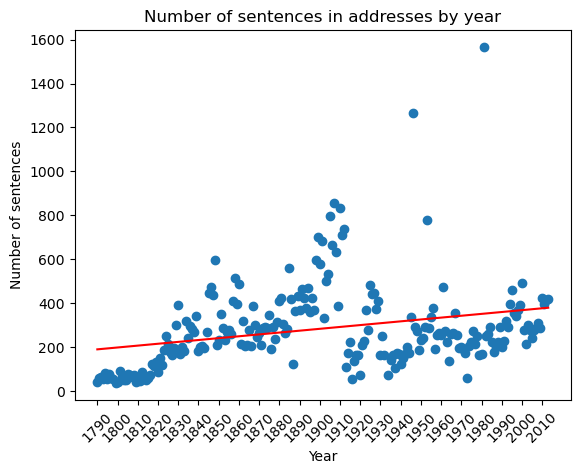

In [19]:
import re

number_of_sentences = df.groupby('year')['length'].count()


index = np.array([int(s) for s in number_of_sentences.index.values])

fit_and_plot(index, number_of_sentences)

plt.ylabel('Number of sentences')
plt.title('Number of sentences in addresses by year')

Plot and fit a linear regression model to the mean sentence length in words 

Text(0.5, 1.0, 'Mean sentence length in words by year')

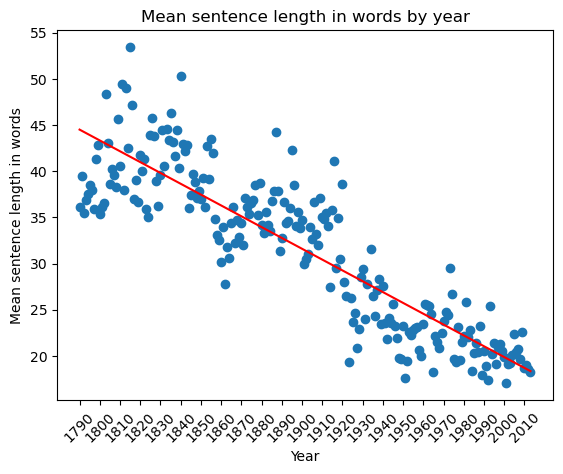

In [20]:

df['length_in_words'] = df['sentence'].apply(lambda s: len(re.split(r'\W+', s)))
mean_sentence_length_in_words = df.groupby('year')['length_in_words'].mean()

fit_and_plot(index, mean_sentence_length_in_words)
plt.ylabel('Mean sentence length in words')
plt.title('Mean sentence length in words by year')

The number of sentences in the address grows over the year, while the mean sentence length in words decreases over time. The decreasing trend is quite significant from the plot. In other words, although there are more sentences in one address, shorter sentences are used.

## (d)
Now, we want to fit two linear models for the number of words in a SOU versus year: one for the years 1790 to 1912, another for the years 1913 to the present using one multiple linear regression model.



### i. 
How would you set up the multiple regression model?

We can introduce dummy variables to encode the group. 
$$
I = 
\left\{
\begin{aligned}
& 0, & \text{if } 1790 \leq x \leq 1912, \\
& 1, & \text{otherwise.}
\end{aligned}
\right.
$$

We can use the following multiple linear regression model:
$y = \beta_0 + \beta_1 \cdot I + \beta_2 x + \beta_3 x \cdot I$

### ii. 
Explain the advantage of using multiple regression vs. estimating a separate linear regression for each group.

In conducting inference about the differences between two groups, specifically pre and post 1912, we can evaluate the significance of the change in trend by examining the p-values of $\beta_1$ and $\beta_2$ easily in the multiple regression model. In addition, by combining the data, we can get bigger power (less variance), which would benefit the statistical testing.

### iii.
Compute the estimated coefficients yourself (again, do not use a linear regression package) and plot the two lines you get. What trends do you see? Lookup the history of the State of the Union addresses (for example on Wikipedia) to explain the regressions.

In [21]:
index = index.reshape(-1, 1)
index_augmented = np.hstack((np.where(index <= 1912, 0, 1), index, np.where(index <= 1912, 0, index)))

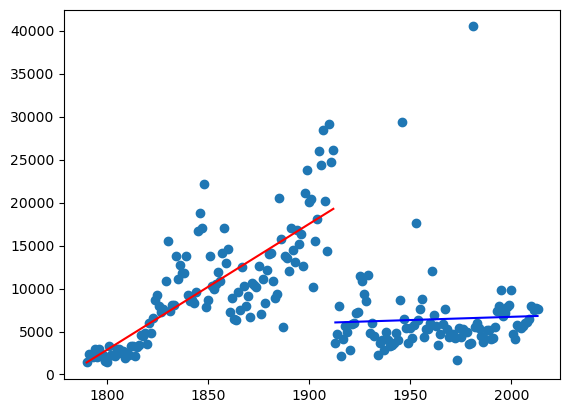

In [22]:
number_of_words = df.groupby('year')['length_in_words'].sum()
beta_0, beta_1, beta_2, beta_3 = fit_linear_regression(index_augmented, np.array(number_of_words).reshape(-1, 1))
x_values_0 = np.linspace(1790, 1912, 100)
y_values_0 = beta_0 + beta_2 * x_values_0
plt.plot(x_values_0, y_values_0, color='red')

x_values_1 = np.linspace(1913, 2013, 100)
y_values_1 = beta_0 + beta_1 + (beta_2 + beta_3)* x_values_1
plt.plot(x_values_1, y_values_1, color='blue')

plt.scatter(index, number_of_words)

President Woodrow Wilson, who took office in 1913, revived the practice of delivering the speech in person, a tradition that had not been followed for over a century.